In [234]:
import ira
%alphalab dark

%run initlibs.py Lustre dark
from tools.loaders.data_loaders import load_data, ls_symbols_hdf

import qlearn as q
from qlearn.core.generators import CrossingMovings
%run trackers.py 
%run generators.py

# Tracking rules (Pyramiding)

Here we will test position size pyramiding technic. 

This is implemented as separate position tracker module (see class Pyramiding at **tracker.py**) and can be combined with any entry signals generator. 

At first step we will apply it to our basic breakout model.

When our model generates signal (long or short) it triggers tracker. Tracker in it's turn processes this signal by opening actual position (or skipping signal if it's not allowed at the moment). Also it takes care about control actual postions (moving trailing stops, increasing position size, close by stops etc).

<b>Pyramiding tracker has following parameters</b>
<hr/>

   - <font color='orange'>size</font>: basic position size (in contracts). On first entry tracker will buy or sell this amount of contracts.
   - <font color='orange'>stop_mx</font>: how many ATRs we set stop at (<font color='green'>stop = entry_price -/+ stop_mx * ATR</font>)  [default 3]
   - <font color='orange'>next_mx</font>: how many ATRs next level is (<font color='green'>next = entry_price +/- next_mx * ATR</font>) [default 3]
                  At next level tracker may performs following actions:
                      - increase position if level's number >= pyramiding_start_step and it doesn't exceed maximal number of pyramiding positions (see max_position)
                      - pull up/down stop level to breakeven
                      - close position in profit if 
   - <font color='orange'>pyramiding_factor</font>: position decaying factor. On every next step we will add to position: prev_size * pyramiding_factor.
                           For example if pyramiding_factor = 0.5 and size = 10 
                           - at first initial step tracker open 10 contracts
                           - at next step it add 10 * 0.5 = 5 contracts
                           - at third step it adds 5 * 0.5 = 2 contracts
                           - at 4'th step: 2 * 0.5 = 1 contract
                           - at 5'th step 1 * 0.5 = 0 - so it final step and it will close position in profit if flat_on_max_step is set 
                           so 0.5 reproduces classical approach: first 100%, 50%, 25%, 12% ...
                           If pyramiding_factor=1 tracker adds same fixed amount (==size) at every step.
   - <font color='orange'>pyramiding_start_step</font>: level number when it is allowed to increase position.
                          Classical way is to just move stop to breakeven at step 2 (no position increasing) and start pyramiding at step 3 
                          (so pyramiding_start_step = 3 for this case)
   - <font color='orange'>max_positions</font>: maximal allowed number of pyramiding steps
   - <font color='orange'>flat_on_max_step</font>: if this flag is set tracker will close position when max number of position increasig steps reached
   - <font color='orange'>atr_period</font>: period of ATR indicator [default 22]
   - <font color='orange'>atr_timeframe</font>: timeframe for ATR indicator [default daily bars]
   - <font color='orange'>round_size</font>: minimal  [default 1]


<font color='red' size=2><u>Additional rules</u></font>
   1. If tracker receives another signal from signals generator but position is already open (being tracked) this signal will be ignored.
  
<hr/>


Example for <font color='#10ff00'>Pyramiding(size=10, stop_mx=3, next_mx=3, pyramiding_factor=0.5, max_positions=5, flat_on_max_step=True, pyramiding_start_step=3, round_size=1)</font>

- Signal generator produces signal to oen long position, current price is \\$100.00, ATR=5.00

- Tracker will open 10 contracts long at \\$100.00 and set up stop at 100 - 3 * 5 = \\$85, next level (#2) is 100 + 3 * 5 = \\$115

- If price drops below \\$85 tracker will close position

- If price goes above \\$115 tracker will do following actions:
   - just pull up stop at breakeven level at entry price = \\$100.00 because pyramiding should start from level N 3 but it's N 2
   - calculate ATR at this moment, let's say it's 7
   - starts waiting for next level (N3) == 115 + 3 * 7 = \\$136.00
   
   
- When (if) price touches level N3 (\\$136) tracker will:
  - add to first 10 contracts another 10 * 0.5 = 5 contracts and position now is 15
  - calculate position price, it will be (10 * 100 + 5 * 136)/15 = \\$112
  - calculate ATR, let's say it's 3
  - set stop level at 112 - 3 * 3 = \\$103
  - calculate next level N4 == 136 + 3 * 3 = \\$145 (here it uses entry price 136 not average position price !!!)
   

- When price reaches level N4 at let's (price is 145.00):
  - add to existing 15 contracts another 5 * 0.5 = 2.5 -> 2 contracts (we round it on round_size=1) and position now is 17
  - position size is (10 * 100 + 5 * 136 + 2 * 145)/17 = 115.88
  - calculate ATR, let's say it's 4
  - move stop to 115.88 - 3 * 4 = 103.88
  - next level (#5) is 145 + 3*4 = \\$157
  
  
- When price touches level #5 at \\$157 tracker will close position at take because max_positions is set to 5 and flat_on_max_step=True

<hr/>


# Test basic parameters

In [67]:
spreads = { 'AUS200': 15*0.1, 'SPXM': 5*0.1, 'XTIUSD': 5*0.01, }
md = load_data('amp:SPXM', 'amp:AUS200', 'amp:XTIUSD')

We will use optimal parameters for signals generator on daily timeframe found on previous research.

In [69]:
G = q.SingleInstrumentComposer(Lustre('1d', 14, 0.75, 25, 10)).fit(md.ticks())

As trackers parametrs we will use classical setup: 
   - 3 atr stop, 3 atr next level, ]
   - no take profit - position may be closed only by trailing stop
   - pyramiding starts from level 3 (so from 6 atr from initial entry)
   - no any restrictions on number of pyramiding entries,
   - position sizes = N * (1, 0.5, 0.25, 0.12, 0.06, ...) - so it's limited only when this progression reaches size < 1 contract !

We will run simulation on 3 CFDs daily prices we used before (AUS200, XTIUSD, SPXM).

In [73]:
Z0 = q.simulation([
        [G, {
            'SPXM':   Pyramiding(10,  3, 3, 0.5, max_positions=1e8, flat_on_max_step=False),
            'AUS200': Pyramiding(10,  3, 3, 0.5, max_positions=1e8, flat_on_max_step=False),
            'XTIUSD': Pyramiding(100, 3, 3, 0.5, max_positions=1e8, flat_on_max_step=False)
        }],
    ], md.ohlc('1h'), 'stock', 'Lustre Pyramiding', spreads=spreads)

 0: Lustre Pyramiding/0  : Sharpe: -0.23 | Sortino: -0.33 | CAGR: -18.16 | DD: $53348.00 (73.52%) | Gain: $-22377.88 | Execs: 63[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,Lustre Pyramiding/0,-0.233714,-0.332968,-18.164049,53348.0,73.520049,-22377.88,63


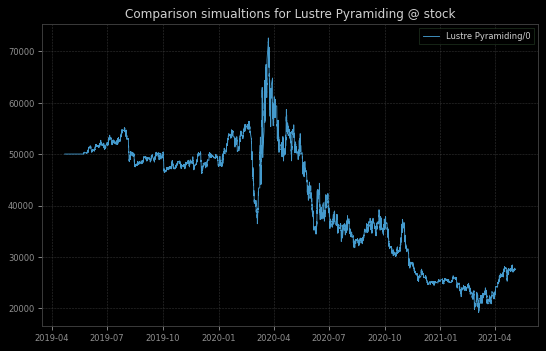

In [72]:
Z0.report(50000)

As we can see overall performance is bad. We can try to play a bit with pyramiding parameters. 

For example we can try to change increasing scheme and use 0.75 factor instead of halving every entry. So on initial 100 constract first pyramiding will add 75 contracts, then 56, then 42, 31, 23 .... so more smooth increasing.

Also from analysis of entries I found that using +3 x ATR as next level and -3 x ATR for stop is not optimal setup, 
and it'd be better to use bit tighter pyramifing level at let's say 1 x ATR and loose stop at -4 x ATR. 

Another moment here - it's more optimal to close at profit when increasing progression reached maximal number of entries, instead of waiting to be flat by trailing stop. 

Here we will use 1:6 as maximal leverage and initial deposit \\$50K

At least all these observations were maid for available data.

In [83]:
tZ = q.simulation([
        [G, {
            'SPXM':   Pyramiding(10,  4, 1, 0.75, 15, flat_on_max_step=True),
            'AUS200': Pyramiding(10,  4, 1, 0.75, 15, flat_on_max_step=True),
            'XTIUSD': Pyramiding(100, 4, 1, 0.75, 15, flat_on_max_step=True)
        }],
    ],  md.ohlc('1h'), 'stock', 'Lustre Pyramiding', spreads=spreads)

 0: Lustre Pyramiding/0  : Sharpe: 1.41 | Sortino: 2.24 | CAGR: 51.25 | DD: $23944.10 (22.18%) | Gain: $120194.08 | Execs: 167[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,Lustre Pyramiding/0,1.409136,2.23675,51.252243,23944.1,22.179209,120194.08,167


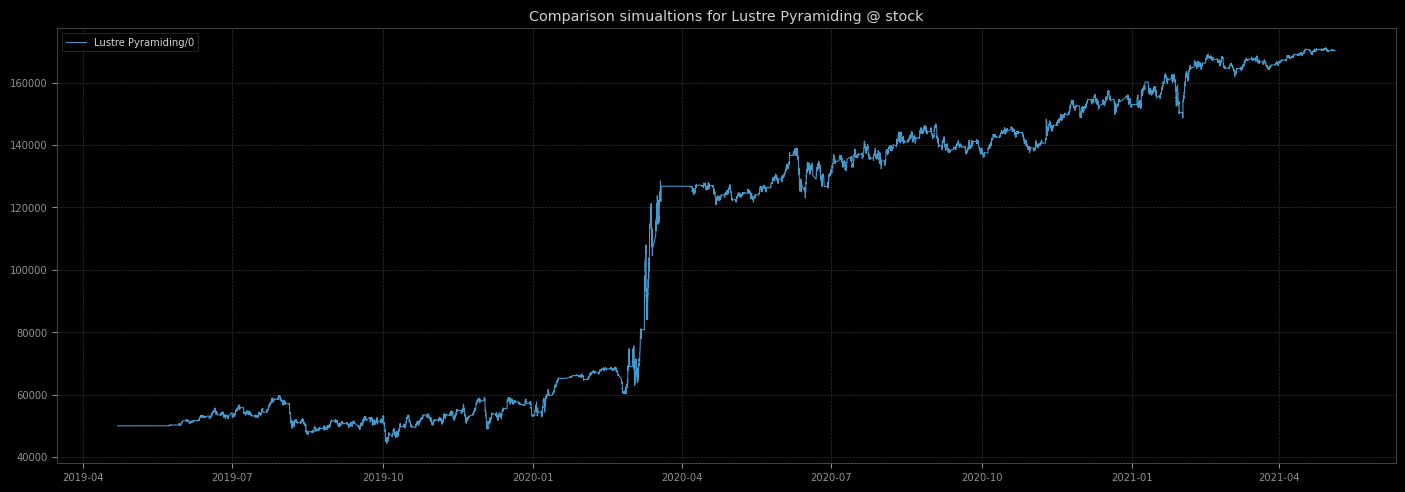

In [87]:
fig(18, 6)
tZ.report(50000)


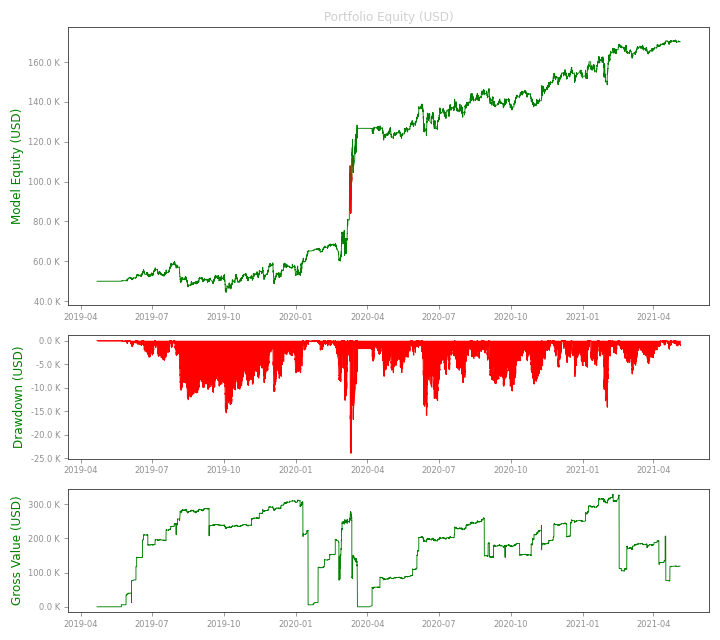

<Figure size 720x640 with 0 Axes>

In [88]:
tearsheet(tZ.results[0].get_portfolio(), 50000)

# Test another signal generator (crossing movings)

As additional step we will test another generator, easiest one is crossing moving averages: 
 - when fast moving average (short period of averaging) crosses slow moving (long period of averaging window) up it generates buy signal
 - when fast moving average crosses slow one down we got sell signal

We will use period 3 as fast period and 34 as slow one trying to catch momentum in price series and run simulations with same pyramiding parameters found on previuos step.

Example of signals of two crossing MA
<hr/>

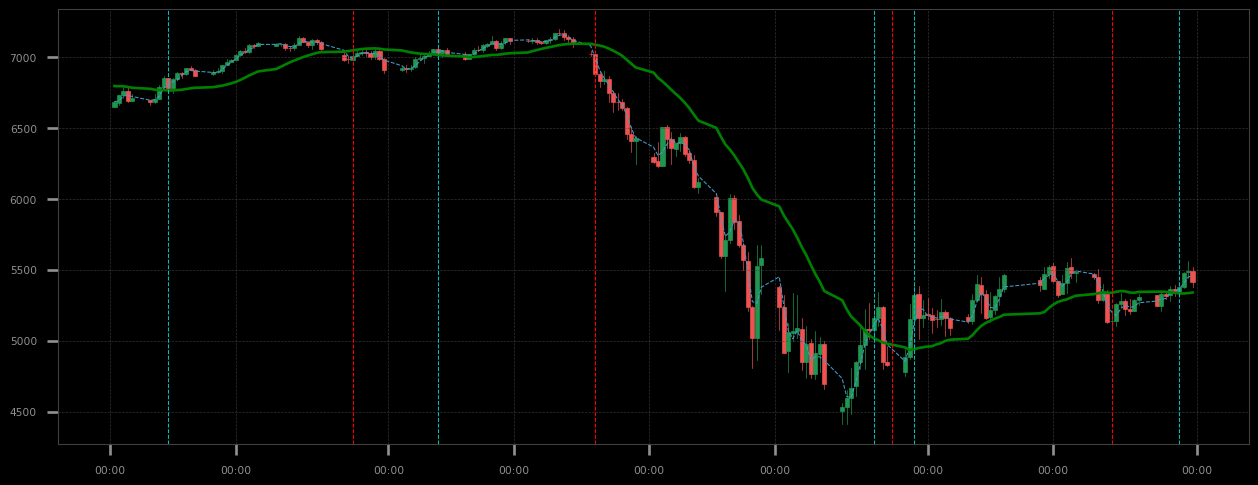

In [233]:
b = md['AUS200'].ohlc('12h')
fas_ma = apply_to_frame(sma, b.close, 3)
slo_ma = apply_to_frame(sma, b.close, 24)

_z = slice('2020-01', '2020-04')
fig(16, 6)
ohlc_plot(b[_z])
plt.plot(fas_ma[_z], '--')
plt.plot(slo_ma[_z], lw=2)

sigs = q.SingleInstrumentComposer(CrossingMovings(3, 24)).fit(md.ticks()).predict(md['AUS200'].ohlcs('12h'))[_z]
[plt.axvline(t, c='c', ls='--') for t,_ in sigs[sigs > 0].dropna().iterrows()];
[plt.axvline(t, c='r', ls='--') for t,_ in sigs[sigs < 0].dropna().iterrows()];

Crossing signals generator

In [204]:
M = q.SingleInstrumentComposer(CrossingMovings(3, 24)).fit(md.ticks())

In [205]:
Zx = q.simulation([
        [M, {
            'SPXM':   Pyramiding(10,  4, 1, 0.75, 15, flat_on_max_step=True),
            'AUS200': Pyramiding(10,  4, 1, 0.75, 15, flat_on_max_step=True),
            'XTIUSD': Pyramiding(100, 4, 1, 0.75, 15, flat_on_max_step=True)
        }],
    ], md.ohlc('12h'), 'stock', 'Lustre Pyramiding', spreads=spreads)

 0: Lustre Pyramiding/0  : Sharpe: 1.20 | Sortino: 2.05 | CAGR: 48.02 | DD: $17944.20 (33.80%) | Gain: $105733.31 | Execs: 107[OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions
0,Lustre Pyramiding/0,1.202274,2.045756,48.022712,17944.2,33.797956,105733.31,107


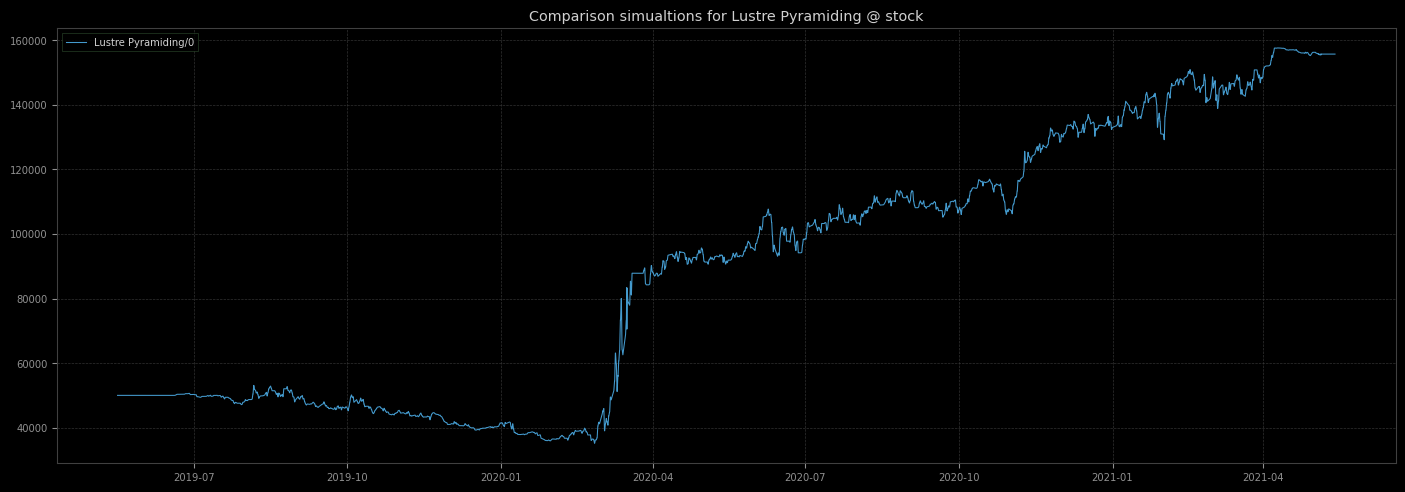

In [235]:
fig(18, 6)
Zx.report(50000)

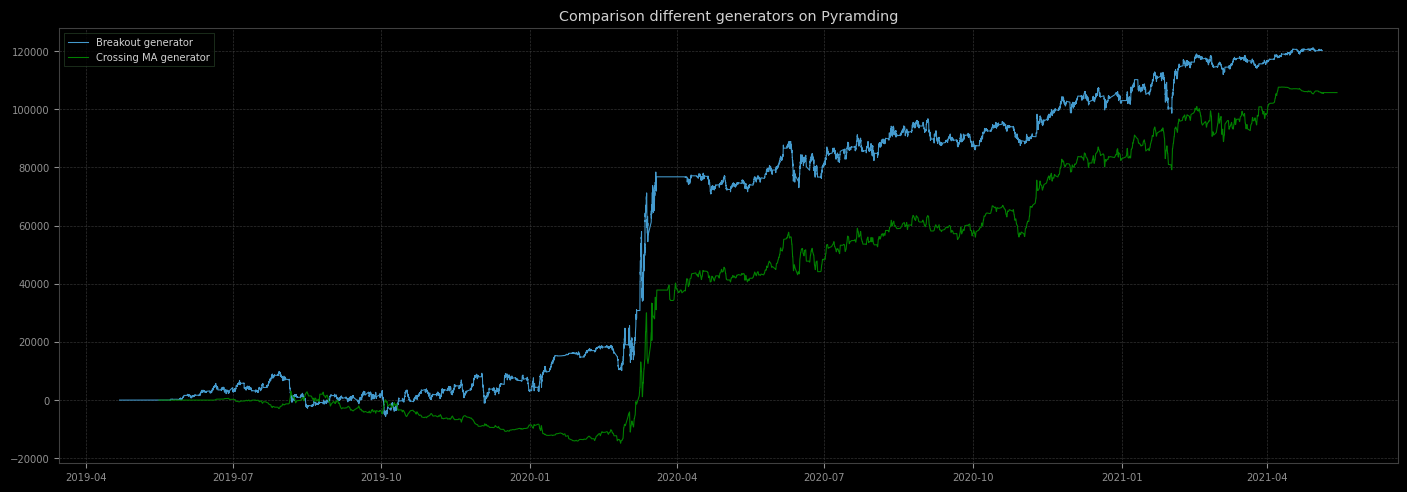

In [239]:
fig(18, 6)
plt.plot(tZ.results[0].equity(), label='Breakout generator')
plt.plot(Zx.results[0].equity(), label='Crossing MA generator')
plt.legend(); plt.title('Comparison different generators on Pyramding');

# Conclusions

<hr/>

As we can see we got significant improve in model by applying optimal pyramiding position sizing. 

 Strategy caught the trend during Mar'2020 and performed more or less well during 'usual' market regime. It processed only 167 trading signals during 2019-now so brokerage fees shouldn't impact performance significantly.

 